# Rosetta Zoo OSIRIS NAC database
This notebook indexes downloaded OSIRIS PDS3 labels according to a configuration file specifying which attributes to scrape. We then do some cleaning, add browse and data product download links and export to a CSV.

In [1]:
from pds3_utils import Database
from IPython.display import Image
from astropy.io import fits
import math
import os
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

Note that pds3_utils is not yet released on github!

In [2]:
data_path = '.'
config_file = './osiris_meta_config.yml'

If `read_labels` is True then all labels will be read, otherwise a previously stored Pickle will be loaded

In [3]:
read_labels = True

In [4]:
if read_labels:
    meta = Database(files='*.LBL', directory=data_path, config_file=config_file, recursive=True)
else:
    dbase = os.path.join(data_path, 'osinac_l3_meta.pkl')
    meta = Database(config_file=config_file)
    meta.load_dbase(dbase)

Extract relevant meta data from all labels, or load from disk (note - this is pretty slow and takes a few hours to run)

In [5]:
if read_labels:
    meta.save_dbase(filename='osinac_l3_meta.pkl', directory=data_path)

In [6]:
images = meta.get_table('osiris_nac_zoo')

In [7]:
len(images)

35179

In [10]:
images.duplicated().sum()

0

## Data cleaning

### Remove images for which we have no surface intercept meta-data

In [11]:
images = images[~images.surf_int_x.isna()]

In [12]:
len(images)

20580

In [13]:
images.head()

,filename,dataset,mission_id,prod_id,start_time,stop_time,instr_id,surf_int_x,surf_int_y,surf_int_z,distance,sc_altitude,phase_angle,sc_position_x,sc_position_y,sc_position_z,sub_sc_lat,sub_sc_lon
0,/home/mbentley/Dropbox/work/esac/osiris_zoo/ex...,RO-C-OSINAC-3-PRL-67PCHURYUMOV-M07-V3.0,ROSETTA,N20140913T214848344ID30F22.FIT,2014-09-13 21:49:57.796,2014-09-13 21:49:58.194,OSINAC,-2.057,-0.169,1.058,28.331,28.70692,63.51151,-12.851,-27.353,3.617,19.1025,160.27464
1,/home/mbentley/Dropbox/work/esac/osiris_zoo/ex...,RO-C-OSINAC-3-PRL-67PCHURYUMOV-M07-V3.0,ROSETTA,N20140914T174755348ID30F22.FIT,2014-09-14 17:49:04.824,2014-09-14 17:49:05.243,OSINAC,2.096,-1.014,0.455,27.978,27.94491,65.74809,-6.03,-27.049,11.858,2.62149,312.43958
2,/home/mbentley/Dropbox/work/esac/osiris_zoo/ex...,RO-C-OSINAC-3-PRL-67PCHURYUMOV-M07-V3.0,ROSETTA,N20140916T023400350ID30F22.FIT,2014-09-16 02:35:09.865,2014-09-16 02:35:10.369,OSINAC,-1.05,0.864,-0.088,27.852,27.26634,77.78793,6.845,-17.802,21.638,-27.21807,103.64506
3,/home/mbentley/Dropbox/work/esac/osiris_zoo/ex...,RO-C-OSINAC-3-PRL-67PCHURYUMOV-M07-V3.0,ROSETTA,N20140920T115325342ID30F22.FIT,2014-09-20 11:54:34.981,2014-09-20 11:54:35.375,OSINAC,1.768,0.298,1.055,25.996,26.21324,64.94366,24.647,4.556,-12.196,10.9404,25.62221
4,/home/mbentley/Dropbox/work/esac/osiris_zoo/ex...,RO-C-OSINAC-3-EXT2-67PCHURYUMOV-M30-V3.0,ROSETTA,N20160613T174910465ID30F22.FIT,2016-06-13 17:50:36.952,2016-06-13 17:50:37.065,OSINAC,-1.153,0.718,-0.2,27.411,27.20704,64.79065,-15.551,19.023,14.542,-40.26319,138.71655


### Remove images > 50km

In [14]:
images = images[images.distance < 50.0]

In [15]:
len(images)

10352

## Add image half-width

OSIRIS NAC FOV: 2.2 degrees

In [16]:
nac_fov = 2.2 # degrees

In [17]:
images['half_width'] = math.sin(math.radians(nac_fov)) * images.sc_altitude

## Add browse image links

It would be nice to have a thumbnail URL for each of these so that we can quickly view pairs... We could get this from EPN-TAP, but it's probably easier to simply construct the URL, for example:

https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-C-OSINAC-2-PRL-67PCHURYUMOV-M06-V3.0/BROWSE/N20140825T204256587ID20F22.JPG

i.e.

https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/{dataset}/BROWSE/{prod_ud-'.FIT}.JPG

In [18]:
images['browse_url'] = images.apply(lambda row: 
    'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/{:s}/BROWSE/{:s}.JPG'.format(row.dataset, row.prod_id[:-4]), axis=1)

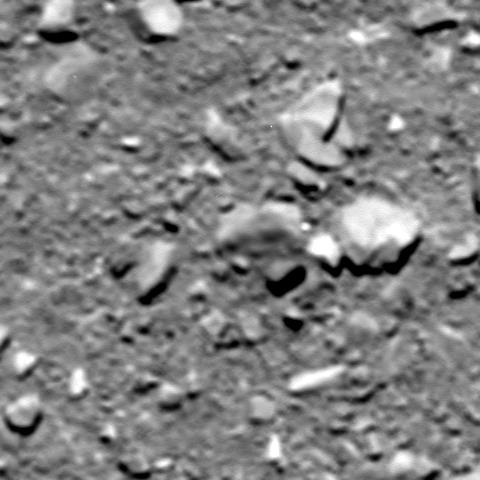

In [19]:
Image(images.browse_url.iloc[-1], width=500) 


## Add data links

There are two ways to do this - use the download URL provided by EPN-TAP:

https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-A-OSINAC-2-AST1-STEINSFLYBY-V1.4:DATA:N20080807T023124677ID20F22

but this would result in a ZIP, or as per the browse image access the files endpoint directly:

In [20]:
images['data_url'] = images.apply(lambda row: 
    'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/{:s}/DATA/FIT/{:s}.FIT'.format(row.dataset, row.prod_id[:-4]), axis=1)

Test this to be sure we can extract a FITS file easily...

In [21]:
f = fits.open(images.data_url.iloc[-1])

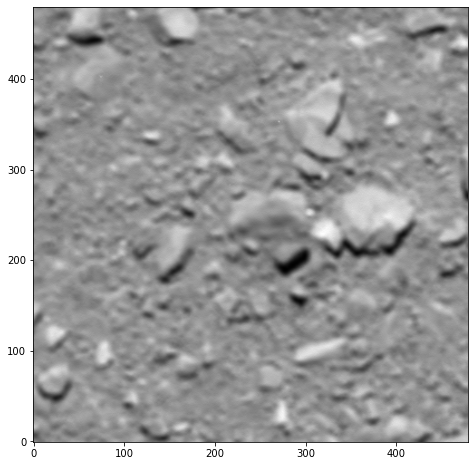

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(f[0].data, cmap=plt.cm.gray, origin='lower', interpolation=None)

## Check the fields in one example

In [23]:
images.iloc[0]

filename         /home/mbentley/Dropbox/work/esac/osiris_zoo/ex...
dataset                    RO-C-OSINAC-3-PRL-67PCHURYUMOV-M07-V3.0
mission_id                                                 ROSETTA
prod_id                             N20140913T214848344ID30F22.FIT
start_time                              2014-09-13 21:49:57.796000
stop_time                               2014-09-13 21:49:58.194000
instr_id                                                    OSINAC
surf_int_x                                                  -2.057
surf_int_y                                                  -0.169
surf_int_z                                                   1.058
distance                                                    28.331
sc_altitude                                               28.70692
phase_angle                                               63.51151
sc_position_x                                              -12.851
sc_position_y                                              -27

# Save the output table

In [25]:
images.to_csv(os.path.join(data_path, 'osinac_metadata.csv.gz'), index=False)